In [66]:
import torch
from torchvision import transforms, datasets
from torchvision.transforms import  ToTensor
import os

In [67]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Grayscale(num_output_channels=1),
    transforms.Normalize([0.5], [0.5])
])



In [68]:
# path 
batch_path = os.getcwd()

path_train = os.path.join(batch_path, '..', 'data_fruit/train')
path_test = os.path.join(batch_path, '..', 'data_fruit/test')

In [69]:
print(path_train)
print(path_test)
 



c:\Users\sumit\OneDrive\Desktop\project work\fruit-classification-pytorch\notebook\..\data_fruit/train
c:\Users\sumit\OneDrive\Desktop\project work\fruit-classification-pytorch\notebook\..\data_fruit/test


In [70]:
train_dataset = datasets.ImageFolder(
    root=path_train,
    transform=transform
)

test_dataset = datasets.ImageFolder(
    root=path_test,
    transform=transform
)


In [71]:
image, label = train_dataset[0]
class_name = train_dataset.classes

In [72]:
image.shape, class_name[label]

(torch.Size([1, 224, 224]), 'apple')

(np.float64(-0.5), np.float64(223.5), np.float64(223.5), np.float64(-0.5))

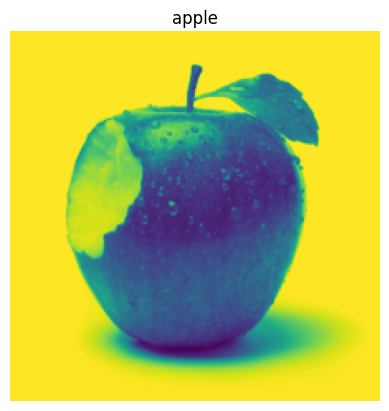

In [73]:
import matplotlib.pyplot as plt

plt.imshow(image.permute(1, 2, 0))
plt.title(class_name[label])
plt.axis("off")


In [74]:
from torch.utils.data import DataLoader

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


In [75]:
len(train_loader), len(train_dataset)

(98, 3115)

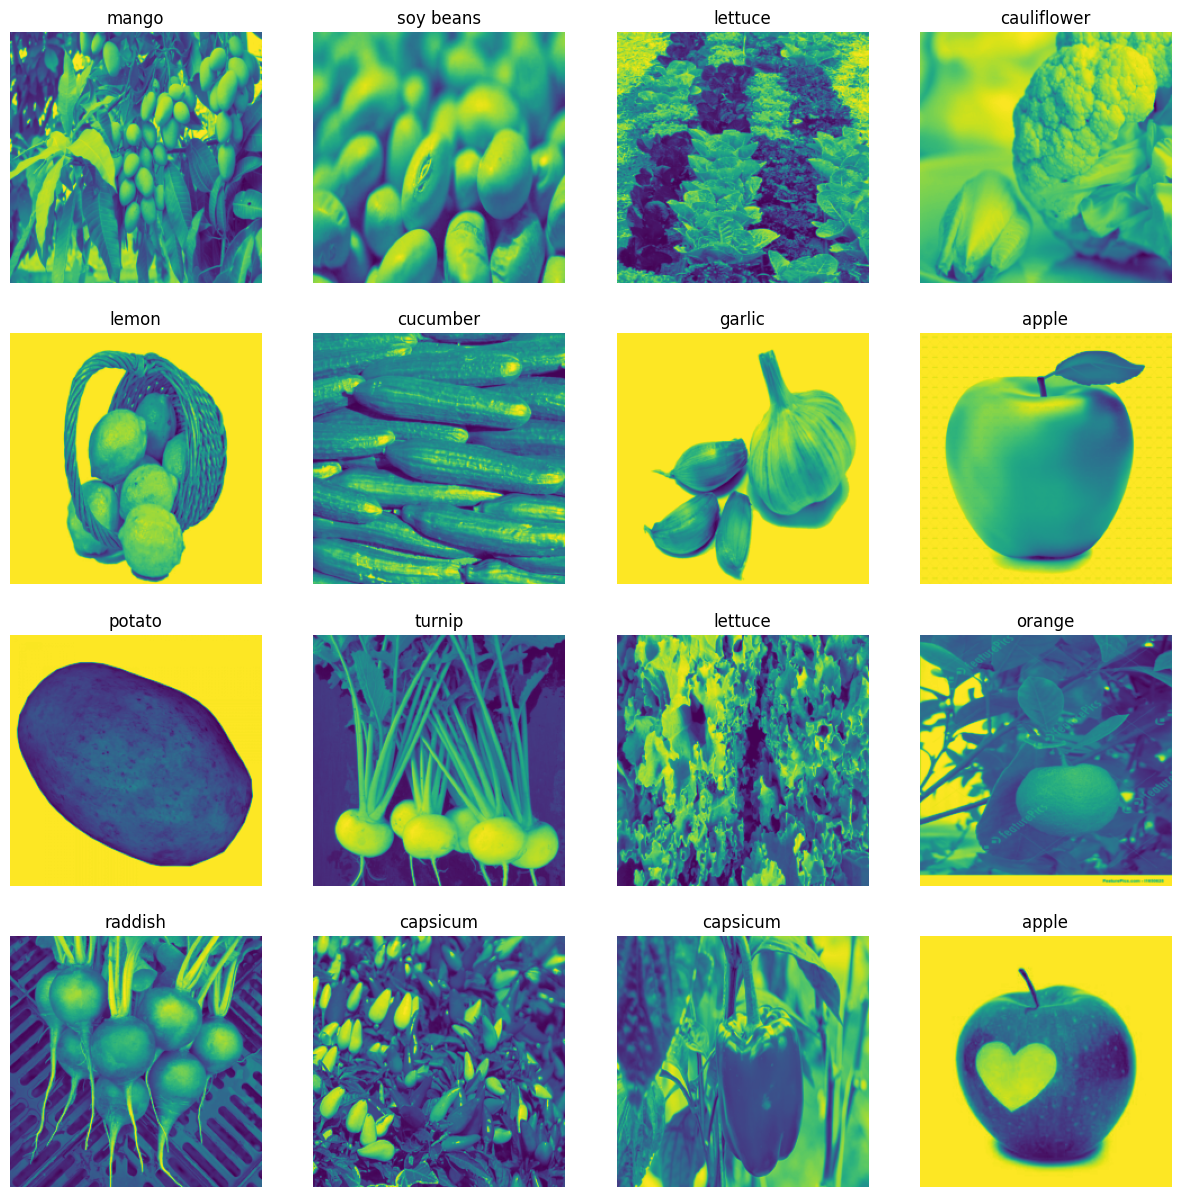

In [76]:
#plot more image
torch.manual_seed(42)
fig = plt.figure(figsize=(15,15))
row, col = 4, 4
for i in range(1, row*col+1):
    rand_idx = torch.randint(0, len(train_dataset), size=[1]).item()
    img, label = train_dataset[rand_idx]
    plt.subplot(row, col, i)
    plt.imshow(img.permute(1, 2, 0))
    plt.title(class_name[label])
    plt.axis(False)


In [77]:
#let check out what we've created

print(f'DataLoader: {train_loader, test_loader}')
print(f'length of train_dataloader: {len(train_loader)}, batch size : {train_loader.batch_size}')
print(f'length of test_dataloader: {len(test_loader)}, batch size : {test_loader.batch_size}')


DataLoader: (<torch.utils.data.dataloader.DataLoader object at 0x0000026DDB1CFBF0>, <torch.utils.data.dataloader.DataLoader object at 0x0000026D845F2B70>)
length of train_dataloader: 98, batch size : 32
length of test_dataloader: 12, batch size : 32


In [84]:
from torch import nn
class FruitModelV1(nn.Module):

    def __init__(self, num_classes):
        super().__init__()

        self.conv_block1 = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )

        self.conv_block2 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )

        self.conv_block3 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )

        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(128 * 28 * 28, 256),
            nn.ReLU(),
            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        x = self.conv_block1(x)
        x = self.conv_block2(x)
        x = self.conv_block3(x)
        x = self.classifier(x)
        return x


In [85]:
torch.manual_seed(42)
model = FruitModelV1(num_classes=len(class_name))

In [86]:
loss_fun = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=model.parameters(), lr=0.001)
def accuracy(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item()
    acc = (correct/len(y_pred))*100

    return acc



In [87]:
def train_step(model:torch.nn.Module,
               data : torch.utils.data.DataLoader,
               loss_fun:torch.nn.Module,
               optimizer:torch.optim.Optimizer,
               accuracy_fun,
             ):
    train_loss, train_acc = 0, 0
    model.train()

    for batch, (x,y) in enumerate(data):
        y_pred = model(x)
        loss = loss_fun(y_pred, y)
        train_loss += loss.item()

        train_acc += accuracy_fun(y_true=y, y_pred=y_pred.argmax(dim=1))

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    train_loss /= len(data)
    train_acc /= len(data)

    print(f'train loss : {train_loss:.5f}| train accuracy: {train_acc:.2f}%')    

In [88]:
def test_step(model:torch.nn.Module,
               data : torch.utils.data.DataLoader,
               loss_fun:torch.nn.Module,
               accuracy_fun,
             ):
    test_loss, test_acc = 0, 0
    model.eval()
    with torch.inference_mode():
        for batch, (x,y) in enumerate(data):
            y_pred = model(x)
            loss = loss_fun(y_pred, y)
            test_loss += loss.item()

            test_acc += accuracy_fun(y_true=y, y_pred=y_pred.argmax(dim=1))
    
    test_loss /= len(data)
    test_acc /= len(data)

    print(f'test loss : {test_loss:.5f}| test accuracy: {test_acc:.2f}%')    

In [ ]:
torch.manual_seed(42)
from tqdm.auto import tqdm

epochs = 3

for epoch in tqdm(range(epochs)):
    print(f'Epoch : {epoch}\n\n-------------')
    train_step(
        model=model,
        data=train_loader,
        loss_fun=loss_fun,
        optimizer=optimizer,
        accuracy_fun=accuracy,
        
    )
    test_step(
        model=model,
        data=test_loader,
        loss_fun=loss_fun,
        accuracy_fun=accuracy,
        
    )


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch : 0

-------------


c:\Users\sumit\AppData\Local\Programs\Python\Python312\Lib\site-packages\PIL\Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


In [ ]:
def make_prediction(
        model:torch.nn.Module,
        data:list,
        
                                    ):
    pred_probs = []
    model.eval()
    with torch.inference_mode():
        
        for sample in data:
            sample = torch.unsqueeze(sample, dim=0)

            pred_logit = model(sample)

            pred_prob = torch.softmax(pred_logit.squeeze(), dim=0)

            pred_probs.append(pred_prob.cpu())
    return torch.stack(pred_probs)


In [ ]:

y_pred = []

model.eval()
with torch.inference_mode():
    for x, y in tqdm(test_loader, desc='making prediction..........'):
        y_logist = model(x)

        y_preds = torch.softmax(y_logist.squeeze(), dim=0).argmax(dim=1)

        y_pred.append(y_preds)

y_pred_tensor = torch.cat(y_pred)
y_pred_tensor

In [ ]:
y_preds = []
y_true = []

model.eval()

with torch.inference_mode():
    for X, y in train_loader:
        X = X
        y = y

        logits = model(X)
        preds = torch.argmax(logits, dim=1)

        y_preds.append(preds.cpu())
        y_true.append(y.cpu())


In [ ]:
y_pred_tensor = torch.cat(y_preds)
y_true_tensor = torch.cat(y_true)


In [ ]:
from torchmetrics import ConfusionMatrix
from mlxtend.plotting import plot_confusion_matrix

confmat = ConfusionMatrix(task="multiclass", num_classes=len(class_name))

confmat_tensor = confmat(
    preds=y_pred_tensor,
    target=y_true_tensor
)

fig, ax = plot_confusion_matrix(
    conf_mat=confmat_tensor.numpy(),
    class_names=class_name,
    figsize=(20, 10)
)


In [ ]:
import random
# random.seed(42)
test_sample = []
test_label = []
for sample, label in random.sample(list(test_dataset), k=9):
    test_sample.append(sample)
    test_label.append(label)
test_sample[0].shape


In [ ]:
#make predications
pred_probs = make_prediction(model=model,
                             data=test_sample)

pred_classes = pred_probs[:2].argmax(dim=1)

In [ ]:
# plot predictions

plt.figure(figsize=(9,9))
nrows = 3
ncols = 3
for i, sample in enumerate(test_sample):
    plt.subplot(nrows, ncols, i+1)
    plt.imshow(sample.squeeze(), cmap='gray')

    pred_label = class_name[pred_classes[i]]

    truth_label = class_name[test_label[i]]

    title_text = f'pred: {pred_label} | truth {truth_label}'

    if pred_label == truth_label:
        plt.title(title_text, fontsize=10, c='g')

    else:
        plt.title(title_text, fontsize=10, c='r')
    plt.axis(False)